<a href="https://colab.research.google.com/github/buriro-ezekia/To-investigate-the-challenges-facing-the-implementation-of-PEPMIS/blob/main/PEPMIS_Survey_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analysis Objectives

- Identify which challenges (training, ICT access, system failure, workload, support, motivation, communication) are most severe.

- Compare perceptions across demographic groups (sex, age, education level, working experience).




### Data Preparation


In [ ]:
#!/usr/bin/env python3
"""
Data preparation for:
drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified.csv

Same behaviour as before but avoids raising SystemExit in interactive sessions.
"""
import re
import sys
from pathlib import Path
import numpy as np
import pandas as pd

INPUT = Path("drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified.csv")
OUTPUT = INPUT.parent / (INPUT.stem + "_cleaned" + INPUT.suffix)

LIKERT_COLUMNS = [
    "Training_Gap_PEPMIS",
    "Limited_Access_ICT",
    "PEPMIS_System_Failures",
    "Workload_Time_Barrier",
    "Limited_Tech_Support",
    "Low_Motivation_PEPMIS",
    "Communication_Gap_PEPMIS",
]

def parse_likert(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, (int, float)) and not np.isnan(value):
        try:
            iv = int(value)
            if 1 <= iv <= 5:
                return iv
        except Exception:
            pass
    s = str(value).strip().lower()
    if s == "":
        return np.nan
    m = re.search(r"\b([1-5])\b", s)
    if m:
        return int(m.group(1))
    text_map = {
        "strongly agree": 5,
        "agree": 4,
        "neutral": 3,
        "neither agree nor disagree": 3,
        "disagree": 2,
        "strongly disagree": 1,
        "sa": 5,
        "a": 4,
        "n": 3,
        "d": 2,
        "sd": 1,
    }
    for key, val in text_map.items():
        if key in s:
            return val
    return np.nan

def safe_strip_df(df):
    obj_cols = df.select_dtypes(include=['object']).columns
    for col in obj_cols:
        df[col] = df[col].map(lambda x: x.strip() if isinstance(x, str) else x)
    return df

def normalize_age(age_val):
    if pd.isna(age_val):
        return age_val
    s = str(age_val).strip().replace("–", "-").replace("—", "-")
    s = s.replace(" years", "").strip()
    return s

def normalize_experience(exp_val):
    if pd.isna(exp_val):
        return exp_val
    s = str(exp_val).strip().lower()
    s = s.replace("less than 5 years", "<5").replace("above 15 years", ">15")
    s = s.replace("years", "").replace(" ", "").replace("–", "-")
    s = s.replace("less", "<").replace("above", ">")
    s = s.replace("lt", "<").replace("gt", ">")
    s = s.replace("5-10years", "5-10").replace("11-15years", "11-15")
    return s

def main():
    if not INPUT.exists():
        print(f"Input file not found: {INPUT}", file=sys.stderr)
        return 1

    df = pd.read_csv(INPUT, parse_dates=["Timestamp"], dayfirst=True, keep_default_na=True)
    original_rows = len(df)
    df = safe_strip_df(df)

    if "Age" in df.columns:
        df["Age_clean"] = df["Age"].map(normalize_age)
    else:
        df["Age_clean"] = pd.NA

    if "Working_Experience" in df.columns:
        df["Working_Experience"] = df["Working_Experience"].map(normalize_experience)

    before_dup = len(df)
    df = df.drop_duplicates(keep='first').reset_index(drop=True)
    dup_removed = before_dup - len(df)

    for col in LIKERT_COLUMNS:
        if col in df.columns:
            df[col] = df[col].map(parse_likert)
        else:
            df[col] = np.nan

    before_drop_all_likert = len(df)
    df = df.dropna(axis=0, how='all', subset=LIKERT_COLUMNS).reset_index(drop=True)
    dropped_all_likert = before_drop_all_likert - len(df)

    df["Age_clean"] = pd.Categorical(df["Age_clean"])

    experience_order = ["<5", "5-10", "11-15", ">15"]
    if set(df["Working_Experience"].dropna().unique()).intersection(set(experience_order)):
        df["Working_Experience"] = pd.Categorical(df["Working_Experience"],
                                                  categories=experience_order,
                                                  ordered=True)

    df.to_csv(OUTPUT, index=False)

    print("Data prep complete.")
    print(f"Input file: {INPUT}")
    print(f"Output file: {OUTPUT}")
    print(f"Original rows: {original_rows}")
    print(f"Exact duplicate rows removed: {dup_removed}")

    print("Likert invalid/missing counts (per column) after parsing:")
    for col in LIKERT_COLUMNS:
        missing = int(df[col].isna().sum())
        print(f"  {col}: {missing} missing/invalid")

    print("Missing values per column (final):")
    for col in df.columns:
        missing = int(df[col].isna().sum())
        print(f"  {col}: {missing}")

    print("\nNotes:")
    print("- Likert values mapped by extracting leading digit or matching common labels.")
    print("- Invalid/unmapped likert items set to NA. Rows with all Likert items missing were dropped.")
    print("- Demographics converted to categorical (ordered where sensible).")
    print("- No reverse-scoring applied (as requested).")

    # Return exit code for external callers, but do not raise SystemExit here.
    return 0

if __name__ == "__main__":
    # In a terminal this is equivalent to sys.exit(main()), but in interactive
    # sessions calling main() directly avoids showing SystemExit as an exception.
    exit_code = main()
    # If you want the session to actually exit when run as a script, uncomment:
    # if exit_code != 0:
    #     raise SystemExit(exit_code)

Data prep complete.
Input file: drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified.csv
Output file: drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified_cleaned.csv
Original rows: 27
Exact duplicate rows removed: 0
Likert invalid/missing counts (per column) after parsing:
  Training_Gap_PEPMIS: 0 missing/invalid
  Limited_Access_ICT: 0 missing/invalid
  PEPMIS_System_Failures: 0 missing/invalid
  Workload_Time_Barrier: 0 missing/invalid
  Limited_Tech_Support: 0 missing/invalid
  Low_Motivation_PEPMIS: 0 missing/invalid
  Communication_Gap_PEPMIS: 0 missing/invalid
Missing values per column (final):
  Timestamp: 0
  Age: 0
  Sex: 0
  Education_Level: 0
  Working_Experience: 0
  Training_Gap_PEPMIS: 0
  Limited_Access_ICT: 0
  PEPMIS_System_Failures: 0
  Workload_Time_Barrier: 0
  Limited_Tech_Support: 0
  Low_Motivation_PEPMIS: 0
  Communication_Gap_PEPMIS: 0
  Age_clean: 0

Notes:
- Likert values mapped by extracting leading digit or

### Descriptive Analysis

**Purpose:** Summarise teacher perceptions of each challenge.

In [ ]:
#!/usr/bin/env python3
"""
Descriptive analysis for PEPMIS challenge items.

Reads:
  drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified_cleaned.csv

Produces:
  - pepmis_descriptive_summary.csv  (per-item stats and counts)
  - mean_challenge_scores.png
  - stacked_response_distribution.png

What changed:
  - Replaced seaborn.barplot (which raised a FutureWarning about palette usage
    without hue) with a simple matplotlib bar chart using a viridis colormap.
    This gives the same plot without the warning.
"""
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# INPUT: change this if your cleaned file is elsewhere
INPUT = Path("drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified_cleaned.csv")
OUTPUT_SUMMARY = Path("pepmis_descriptive_summary.csv")
PLOT_MEAN = Path("mean_challenge_scores.png")
PLOT_STACKED = Path("stacked_response_distribution.png")

LIKERT_COLUMNS = [
    "Training_Gap_PEPMIS",
    "Limited_Access_ICT",
    "PEPMIS_System_Failures",
    "Workload_Time_Barrier",
    "Limited_Tech_Support",
    "Low_Motivation_PEPMIS",
    "Communication_Gap_PEPMIS",
]

def load_data(path):
    if not path.exists():
        print(f"Input file not found: {path}", file=sys.stderr)
        sys.exit(1)
    df = pd.read_csv(path, parse_dates=["Timestamp"], dayfirst=True, keep_default_na=True)
    return df

def descriptive_stats(df, items):
    rows = []
    for col in items:
        if col not in df.columns:
            rows.append({
                "item": col,
                "mean": np.nan,
                "median": np.nan,
                "std": np.nan,
                "n_non_missing": 0,
                "n_missing": 0,
                "percent_agree_or_strongly": np.nan,
                "count_1": 0,
                "count_2": 0,
                "count_3": 0,
                "count_4": 0,
                "count_5": 0,
            })
            continue

        series = pd.to_numeric(df[col], errors='coerce')
        n_missing = int(series.isna().sum())
        s_nonmiss = series.dropna().astype(int)
        mean = float(s_nonmiss.mean()) if len(s_nonmiss) > 0 else np.nan
        median = float(s_nonmiss.median()) if len(s_nonmiss) > 0 else np.nan
        std = float(s_nonmiss.std(ddof=1)) if len(s_nonmiss) > 1 else 0.0

        counts = {i: int((s_nonmiss == i).sum()) for i in range(1,6)}
        percent_agree = (counts[4] + counts[5]) / max(1, len(s_nonmiss)) * 100 if len(s_nonmiss) > 0 else np.nan

        row = {
            "item": col,
            "mean": round(mean, 3) if not np.isnan(mean) else np.nan,
            "median": int(median) if not np.isnan(median) else np.nan,
            "std": round(std, 3) if not np.isnan(std) else np.nan,
            "n_non_missing": int(len(s_nonmiss)),
            "n_missing": n_missing,
            "percent_agree_or_strongly": round(percent_agree, 1) if not np.isnan(percent_agree) else np.nan,
            "count_1": counts[1],
            "count_2": counts[2],
            "count_3": counts[3],
            "count_4": counts[4],
            "count_5": counts[5],
        }
        rows.append(row)
    summary = pd.DataFrame(rows)
    return summary

def print_ranking(summary):
    ranked = summary.sort_values("mean", ascending=False).reset_index(drop=True)
    print("\nRanking of challenges (highest mean -> lowest mean):")
    for idx, row in ranked.iterrows():
        mean = row["mean"]
        pct = row["percent_agree_or_strongly"]
        print(f"{idx+1}. {row['item']}  — mean {mean}, {pct}% agree/strongly agree")
    highest = ranked.iloc[0]
    lowest = ranked.iloc[-1]
    print("\nHighest scoring challenge:")
    print(f" - {highest['item']} (mean {highest['mean']}, {highest['percent_agree_or_strongly']}% agree/strongly)")
    print("Lowest scoring challenge:")
    print(f" - {lowest['item']} (mean {lowest['mean']}, {lowest['percent_agree_or_strongly']}% agree/strongly)")

def save_plots(df, summary, items):
    sns.set(style="whitegrid")

    # Bar chart of mean scores with error bars (standard error)
    means = []
    sems = []
    labels = []
    for col in items:
        series = pd.to_numeric(df[col], errors='coerce').dropna()
        labels.append(col)
        means.append(series.mean() if len(series) > 0 else 0)
        sems.append(series.sem() if len(series) > 0 else 0)

    # Use matplotlib directly to avoid seaborn palette/hue warning
    plt.figure(figsize=(10,6))
    n = len(labels)
    x = np.arange(n)
    # generate a color for each bar using viridis colormap
    colors = plt.cm.viridis(np.linspace(0, 1, n))
    plt.bar(x, means, color=colors, edgecolor='black')
    # add error bars
    plt.errorbar(x, means, yerr=sems, fmt='none', ecolor='black', capsize=5)
    plt.ylabel("Mean Likert score (1-5)")
    plt.title("Mean PEPMIS Challenge Scores")
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(PLOT_MEAN, dpi=150)
    plt.close()

    # Stacked bar of disagree/neutral/agree percentages per item
    def pct_bands(col):
        s = pd.to_numeric(df[col], errors='coerce').dropna().astype(int)
        total = len(s)
        if total == 0:
            return (0,0,0)
        disagree = ((s <= 2).sum() / total) * 100
        neutral = ((s == 3).sum() / total) * 100
        agree = ((s >= 4).sum() / total) * 100
        return (disagree, neutral, agree)

    data = {"item": [], "Disagree_or_SD": [], "Neutral": [], "Agree_or_SA": []}
    for col in items:
        d, n_val, a = pct_bands(col)
        data["item"].append(col)
        data["Disagree_or_SD"].append(d)
        data["Neutral"].append(n_val)
        data["Agree_or_SA"].append(a)

    pct_df = pd.DataFrame(data).set_index("item")
    pct_df[["Disagree_or_SD","Neutral","Agree_or_SA"]].plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
    plt.ylabel("Percentage (%)")
    plt.title("Response distribution by challenge item")
    plt.legend(loc="upper right")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(PLOT_STACKED, dpi=150)
    plt.close()

def main():
    df = load_data(INPUT)
    summary = descriptive_stats(df, LIKERT_COLUMNS)
    # Save summary CSV
    summary.to_csv(OUTPUT_SUMMARY, index=False)
    print(f"Descriptive summary saved to {OUTPUT_SUMMARY}")
    # Print details
    print("\nPer-item descriptive statistics:")
    for _, row in summary.iterrows():
        print(f"\n{row['item']}:")
        print(f"  Mean = {row['mean']}")
        print(f"  Median = {row['median']}")
        print(f"  Std dev = {row['std']}")
        print(f"  Counts (1..5) = {row['count_1']}, {row['count_2']}, {row['count_3']}, {row['count_4']}, {row['count_5']}")
        print(f"  Percent Agree or Strongly Agree = {row['percent_agree_or_strongly']}%")
        print(f"  Missing = {row['n_missing']}")

    # Print ranking and top/bottom
    print_ranking(summary)

    # Save plots
    save_plots(df, summary, LIKERT_COLUMNS)
    print(f"\nPlots saved: {PLOT_MEAN}, {PLOT_STACKED}")

if __name__ == "__main__":
    main()

Descriptive summary saved to pepmis_descriptive_summary.csv

Per-item descriptive statistics:

Training_Gap_PEPMIS:
  Mean = 4.0
  Median = 4
  Std dev = 1.109
  Counts (1..5) = 2, 1, 1, 14, 9
  Percent Agree or Strongly Agree = 85.2%
  Missing = 0

Limited_Access_ICT:
  Mean = 4.0
  Median = 4
  Std dev = 1.24
  Counts (1..5) = 2, 2, 2, 9, 12
  Percent Agree or Strongly Agree = 77.8%
  Missing = 0

PEPMIS_System_Failures:
  Mean = 3.63
  Median = 4
  Std dev = 1.391
  Counts (1..5) = 4, 2, 2, 11, 8
  Percent Agree or Strongly Agree = 70.4%
  Missing = 0

Workload_Time_Barrier:
  Mean = 3.593
  Median = 4
  Std dev = 1.474
  Counts (1..5) = 4, 3, 3, 7, 10
  Percent Agree or Strongly Agree = 63.0%
  Missing = 0

Limited_Tech_Support:
  Mean = 3.556
  Median = 4
  Std dev = 1.188
  Counts (1..5) = 2, 3, 6, 10, 6
  Percent Agree or Strongly Agree = 59.3%
  Missing = 0

Low_Motivation_PEPMIS:
  Mean = 3.778
  Median = 4
  Std dev = 1.05
  Counts (1..5) = 1, 3, 3, 14, 6
  Percent Agree or S

All seven PEPMIS challenge items record mean scores above 3.5 on the five-point scale, with medians uniformly at 4, showing that the typical teacher response is “Agree” across all areas. The highest-rated challenges are Training Gaps and Limited Access to ICT, each with a mean of 4.0. Training gaps show the strongest consensus, with 85.2% of teachers agreeing or strongly agreeing that this is a major challenge, followed by limited ICT access at 77.8%. Low Motivation (mean = 3.778; 74.1% agreement) and System Failures (mean = 3.63; 70.4% agreement) also represent substantial barriers to effective PEPMIS use.

Workload/Time Barriers and Communication Gaps both record a mean of 3.593 with 63.0% agreement, indicating moderate but persistent challenges. Limited Technical Support is the lowest-ranked item (mean = 3.556; 59.3% agreement), yet it still reflects majority agreement and therefore remains a significant concern. Standard deviations ranging from 1.05 to 1.47 indicate moderate variation in experiences across teachers, and no missing responses were observed for any item.

Overall, the ranking of challenges places Training Gaps and Limited ICT Access as the most critical barriers, followed by Low Motivation, System Failures, Workload/Time Barriers, Communication Gaps, and finally Limited Technical Support. These results demonstrate that capacity and Infrastructure constraints dominate teacher concerns, confirming that PEPMIS challenges are primarily systemic rather than individual in nature.

The practical implication is that immediate priority should be given to structured PEPMIS training and improved ICT infrastructure. Secondary actions should target motivation through supportive supervision and incentives, while also strengthening system reliability, workload management, communication mechanisms, and technical support services.

### Reliability Testing (Internal Consistency)
**Purpose:** Confirm that all PEPMIS challenge items measure the same construct.


In [ ]:
#!/usr/bin/env python3
"""
Compute Cronbach's alpha and item-total stats for the 7 PEPMIS Likert items.

Input:
  drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified_cleaned.csv

Output:
  - pepmis_reliability_summary.csv  (alpha, item-total correlations, alpha-if-deleted)
  - Printed plain-language summary.
"""
from pathlib import Path
import sys
import pandas as pd
import numpy as np

INPUT = Path("drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified_cleaned.csv")
OUTPUT_SUM = Path("pepmis_reliability_summary.csv")

LIKERT_COLUMNS = [
    "Training_Gap_PEPMIS",
    "Limited_Access_ICT",
    "PEPMIS_System_Failures",
    "Workload_Time_Barrier",
    "Limited_Tech_Support",
    "Low_Motivation_PEPMIS",
    "Communication_Gap_PEPMIS",
]

def cronbach_alpha(df_items):
    """
    Compute Cronbach's alpha.
    Uses sample variances (ddof=1).
    Returns alpha (float), var_items (array), var_total (float).
    """
    X = df_items.to_numpy(dtype=float)
    # number of items
    k = X.shape[1]
    # item variances (ddof=1)
    item_vars = np.nanvar(X, axis=0, ddof=1)
    # total score per respondent
    total = np.nansum(X, axis=1)
    total_var = np.nanvar(total, ddof=1)
    if total_var == 0 or np.any(np.isnan(item_vars)):
        return np.nan, item_vars, total_var
    alpha = (k / (k - 1)) * (1 - item_vars.sum() / total_var)
    return float(alpha), item_vars, float(total_var)

def corrected_item_total_correlations(df_items):
    """
    Compute corrected item-total correlations:
    correlation between each item and the sum of the other items.
    Returns a dict {item: correlation}.
    """
    res = {}
    X = df_items.copy().astype(float)
    total = X.sum(axis=1)
    for col in X.columns:
        xi = X[col]
        others = total - xi
        # drop rows where either is NaN
        mask = xi.notna() & others.notna()
        if mask.sum() < 2:
            res[col] = np.nan
            continue
        r = xi[mask].corr(others[mask])
        res[col] = float(r)
    return res

def alpha_if_item_deleted(df_items):
    """
    Compute Cronbach's alpha when each item is removed in turn.
    Returns dict {item: alpha_if_deleted}.
    """
    res = {}
    cols = list(df_items.columns)
    for col in cols:
        keep = [c for c in cols if c != col]
        sub = df_items[keep]
        alpha, _, _ = cronbach_alpha(sub)
        res[col] = float(alpha) if not np.isnan(alpha) else np.nan
    return res

def main():
    if not INPUT.exists():
        print(f"Input file not found: {INPUT}", file=sys.stderr)
        return 1

    df = pd.read_csv(INPUT, parse_dates=["Timestamp"], dayfirst=True, keep_default_na=True)

    # keep only the likert columns and coerce to numeric
    items = [c for c in LIKERT_COLUMNS if c in df.columns]
    df_items = df[items].apply(pd.to_numeric, errors='coerce')

    # 1) Cronbach's alpha
    alpha, item_vars, total_var = cronbach_alpha(df_items)
    alpha = round(alpha, 3) if not np.isnan(alpha) else np.nan

    # 2) corrected item-total correlations
    corr = corrected_item_total_correlations(df_items)
    corr = {k: (round(v, 3) if pd.notna(v) else v) for k, v in corr.items()}

    # 3) alpha if item deleted
    alpha_deleted = alpha_if_item_deleted(df_items)
    alpha_deleted = {k: (round(v, 3) if pd.notna(v) else v) for k, v in alpha_deleted.items()}

    # Save a small summary CSV
    rows = []
    for col in items:
        rows.append({
            "item": col,
            "item_variance": round(float(item_vars[items.index(col)]), 5),
            "corrected_item_total_corr": corr.get(col, ""),
            "alpha_if_item_deleted": alpha_deleted.get(col, ""),
        })
    summary = pd.DataFrame(rows)
    summary.attrs["cronbach_alpha_all_items"] = alpha
    summary.to_csv(OUTPUT_SUM, index=False)

    # Plain-language printed summary
    print("Reliability check (plain language):")
    print(f"- Cronbach's alpha for all {len(items)} items = {alpha}")
    if alpha >= 0.70:
        print("  => This is above 0.70, so the set of questions is reliable.")
    else:
        print("  => This is below 0.70, so reliability is low. See item-level notes below.")

    print("\nCorrected item–total correlations (how well each question lines up with the rest):")
    for col in items:
        val = corr.get(col, None)
        print(f" - {col}: {val}")

    print("\nIf we remove one question at a time, Cronbach's alpha would be:")
    for col in items:
        val = alpha_deleted.get(col, None)
        print(f" - remove {col}: alpha = {val}")

    print(f"\nSummary saved to: {OUTPUT_SUM}")
    print("\nSimple interpretation advice (use if needed):")
    print(" - If alpha >= 0.70: keep the set as is. No urgent action needed.")
    print(" - If alpha < 0.70: look for questions with low corrected item–total correlation (e.g. < 0.30).")
    print("   If any are low, consider removing that question or checking its wording.")
    print(" - Also check 'alpha if item deleted': if alpha rises noticeably when a question is removed,")
    print("   that question may not fit the common construct and should be reviewed.")

    return 0

if __name__ == "__main__":
    exit_code = main()
    # in notebooks you can keep this behavior; in a terminal the program exits normally
    # if needed, uncomment next line to raise SystemExit(exit_code)
    # if exit_code != 0: raise SystemExit(exit_code)

Reliability check (plain language):
- Cronbach's alpha for all 7 items = 0.896
  => This is above 0.70, so the set of questions is reliable.

Corrected item–total correlations (how well each question lines up with the rest):
 - Training_Gap_PEPMIS: 0.723
 - Limited_Access_ICT: 0.796
 - PEPMIS_System_Failures: 0.616
 - Workload_Time_Barrier: 0.672
 - Limited_Tech_Support: 0.824
 - Low_Motivation_PEPMIS: 0.668
 - Communication_Gap_PEPMIS: 0.635

If we remove one question at a time, Cronbach's alpha would be:
 - remove Training_Gap_PEPMIS: alpha = 0.878
 - remove Limited_Access_ICT: alpha = 0.868
 - remove PEPMIS_System_Failures: alpha = 0.892
 - remove Workload_Time_Barrier: alpha = 0.886
 - remove Limited_Tech_Support: alpha = 0.866
 - remove Low_Motivation_PEPMIS: alpha = 0.884
 - remove Communication_Gap_PEPMIS: alpha = 0.887

Summary saved to: pepmis_reliability_summary.csv

Simple interpretation advice (use if needed):
 - If alpha >= 0.70: keep the set as is. No urgent action needed

### Construct Composite Challenge Score
**Purpose:** Create one index reflecting the overall PEPMIS implementation challenge level.


Saved data with Challenge_Index to: drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified_cleaned_with_index.csv
Saved overall index summary to: pepmis_index_summary.csv
Saved index-by-group summary to: pepmis_index_by_group.csv


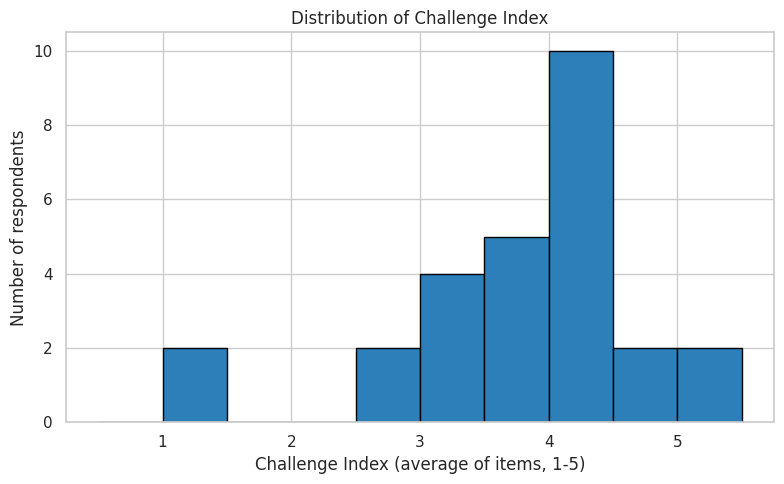

Saved histogram to: challenge_index_histogram.png


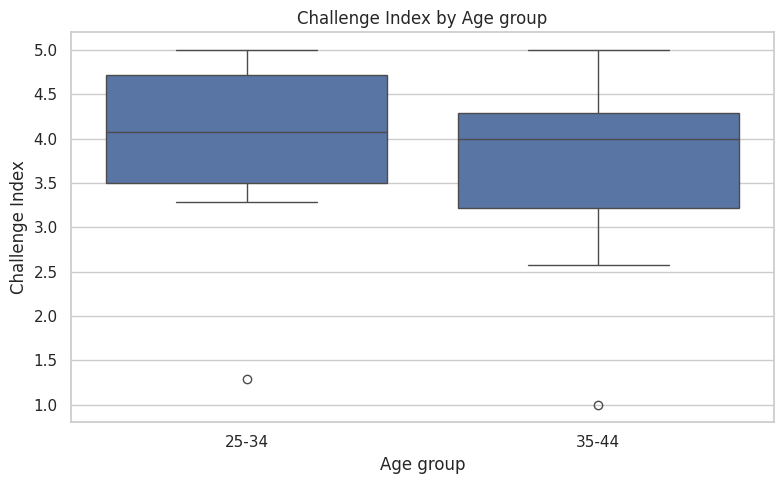

Saved boxplot by Age to: challenge_index_by_age_box.png

Simple summary (plain):
 - Number of rows with computed Challenge_Index: 27
 - Mean Challenge_Index = 3.735
 - Median Challenge_Index = 4.0
 - Std dev = 0.97
Files created: updated data CSV, overall summary CSV, group summary CSV, and two plots.


In [ ]:
#!/usr/bin/env python3
"""
Construct a composite Challenge Index for PEPMIS.

What this script does (plain and simple):
- Loads the cleaned CSV:
    drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified_cleaned.csv
- Computes a Challenge_Index for each row by averaging the seven Likert items.
  - The index is computed only if at least MIN_NON_MISSING of the 7 items are present.
  - If not enough answers, the index is left empty (NaN).
- Appends Challenge_Index to the data and writes a new CSV:
    drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified_cleaned_with_index.csv
- Saves small summary files and plots.
- This version removes the seaborn palette argument that caused the FutureWarning.
"""
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Input / output files (change paths here if needed)
INPUT = Path("drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified_cleaned.csv")
OUTPUT_WITH_INDEX = INPUT.parent / (INPUT.stem + "_with_index" + INPUT.suffix)
SUMMARY_OVERALL = Path("pepmis_index_summary.csv")
SUMMARY_BY_GROUP = Path("pepmis_index_by_group.csv")
PLOT_HIST = Path("challenge_index_histogram.png")
PLOT_BOX_BY_AGE = Path("challenge_index_by_age_box.png")

# The 7 Likert items used to build the index
LIKERT_COLUMNS = [
    "Training_Gap_PEPMIS",
    "Limited_Access_ICT",
    "PEPMIS_System_Failures",
    "Workload_Time_Barrier",
    "Limited_Tech_Support",
    "Low_Motivation_PEPMIS",
    "Communication_Gap_PEPMIS",
]

# Minimum number of non-missing items required to compute the index
MIN_NON_MISSING = 4  # change to 7 if you want to require all answers

def load_data(path):
    if not path.exists():
        print(f"Input file not found: {path}", file=sys.stderr)
        sys.exit(1)
    df = pd.read_csv(path, parse_dates=["Timestamp"], dayfirst=True, keep_default_na=True)
    return df

def compute_challenge_index(df, items, min_non_missing=MIN_NON_MISSING):
    # Ensure items are numeric
    df_items = df[items].apply(pd.to_numeric, errors="coerce")
    # Count how many non-missing items per row
    non_missing_count = df_items.notna().sum(axis=1)
    # Row-wise mean (skipna=True)
    row_mean = df_items.mean(axis=1, skipna=True)
    # Apply threshold: require at least min_non_missing items to compute index
    index = row_mean.where(non_missing_count >= min_non_missing, other=np.nan)
    # Round to 3 decimals for readability
    index = index.round(3)
    return index, non_missing_count

def save_outputs(df, index_series):
    # Attach index to dataframe and save
    df_out = df.copy()
    df_out["Challenge_Index"] = index_series
    df_out.to_csv(OUTPUT_WITH_INDEX, index=False)
    print(f"Saved data with Challenge_Index to: {OUTPUT_WITH_INDEX}")
    return df_out

def save_summaries(df_with_index):
    idx = pd.to_numeric(df_with_index["Challenge_Index"], errors="coerce")
    n = int(idx.count())
    mean = float(idx.mean()) if n > 0 else np.nan
    median = float(idx.median()) if n > 0 else np.nan
    std = float(idx.std(ddof=1)) if n > 1 else 0.0

    overall = pd.DataFrame([{
        "n_non_missing_index": n,
        "mean_index": round(mean, 3) if not np.isnan(mean) else np.nan,
        "median_index": round(median, 3) if not np.isnan(median) else np.nan,
        "std_index": round(std, 3) if not np.isnan(std) else np.nan,
    }])
    overall.to_csv(SUMMARY_OVERALL, index=False)
    print(f"Saved overall index summary to: {SUMMARY_OVERALL}")

    # Group summaries: mean and count for key demographics
    group_vars = ["Sex", "Age_clean", "Education_Level", "Working_Experience"]
    group_rows = []
    for g in group_vars:
        if g in df_with_index.columns:
            grp = df_with_index.groupby(g)["Challenge_Index"].agg(["count", "mean"]).reset_index()
            grp["grouping"] = g
            grp = grp.rename(columns={"count":"n", "mean":"mean_index"})
            group_rows.append(grp)
    if group_rows:
        group_df = pd.concat(group_rows, ignore_index=True, sort=False)
        # Round mean_index
        group_df["mean_index"] = group_df["mean_index"].round(3)
        group_df.to_csv(SUMMARY_BY_GROUP, index=False)
        print(f"Saved index-by-group summary to: {SUMMARY_BY_GROUP}")
    else:
        print("No demographic columns found to create group summaries.")

def save_plots(df_with_index):
    sns.set(style="whitegrid")
    idx = pd.to_numeric(df_with_index["Challenge_Index"], errors="coerce").dropna()

    # Histogram
    plt.figure(figsize=(8,5))
    plt.hist(idx, bins=np.arange(0.5, 5.51, 0.5), color="#2c7fb8", edgecolor="black")
    plt.xlabel("Challenge Index (average of items, 1-5)")
    plt.ylabel("Number of respondents")
    plt.title("Distribution of Challenge Index")
    plt.tight_layout()
    plt.savefig(PLOT_HIST, dpi=150)
    plt.show()
    plt.close()
    print(f"Saved histogram to: {PLOT_HIST}")

    # Boxplot by Age (if Age_clean exists)
    if "Age_clean" in df_with_index.columns:
        plt.figure(figsize=(8,5))
        # Removed 'palette' argument to avoid seaborn FutureWarning about palette without hue
        sns.boxplot(x="Age_clean", y="Challenge_Index", data=df_with_index)
        plt.xlabel("Age group")
        plt.ylabel("Challenge Index")
        plt.title("Challenge Index by Age group")
        plt.tight_layout()
        plt.savefig(PLOT_BOX_BY_AGE, dpi=150)
        plt.show()
        plt.close()
        print(f"Saved boxplot by Age to: {PLOT_BOX_BY_AGE}")
    else:
        print("Age_clean column not found; skipping boxplot by age.")

def main():
    df = load_data(INPUT)
    # Check items exist
    missing_items = [c for c in LIKERT_COLUMNS if c not in df.columns]
    if missing_items:
        print("Warning: the following expected Likert columns are missing from the input:", missing_items)

    index_series, non_missing_count = compute_challenge_index(df, LIKERT_COLUMNS, MIN_NON_MISSING)
    # attach count of non-missing for transparency
    df["likert_non_missing_count"] = non_missing_count
    df_with_index = save_outputs(df, index_series)
    save_summaries(df_with_index)
    save_plots(df_with_index)

    # Plain printed summary
    idx = pd.to_numeric(df_with_index["Challenge_Index"], errors="coerce")
    print("\nSimple summary (plain):")
    print(f" - Number of rows with computed Challenge_Index: {int(idx.count())}")
    if idx.count() > 0:
        print(f" - Mean Challenge_Index = {round(float(idx.mean()),3)}")
        print(f" - Median Challenge_Index = {round(float(idx.median()),3)}")
        if idx.count() > 1:
            print(f" - Std dev = {round(float(idx.std(ddof=1)),3)}")
    print("Files created: updated data CSV, overall summary CSV, group summary CSV, and two plots.")

if __name__ == "__main__":
    main()

**Interpretation of Descriptive Statistics**


---


The mean Challenge Index score of 3.735 on a five-point scale indicates that, on average, teachers rate the challenges associated with PEPMIS between Neutral (3) and Agree (4), with a clear inclination towards Agree. This reflects a moderate to high perceived level of challenge. The median score of 4.0 further confirms this pattern, showing that at least half of the teachers agree that PEPMIS presents notable challenges. The standard deviation of 0.97 indicates a moderate spread of responses, meaning that while many teachers report similar levels of challenge, a meaningful proportion experience either substantially higher or lower levels.

**Implications of the Findings**


---


Overall, the results demonstrate that PEPMIS is widely perceived as a significant challenge rather than a minor issue. The clustering of responses around the “Agree” category shows that concerns are common across the teaching workforce. However, the observed variability suggests that the intensity of these challenges differs across individuals and contexts. This implies that implementation barriers are not uniform and that schools face differing levels of difficulty.

**Practical Implications for Action**


---


Interventions should prioritise the most critical challenges identified, particularly those related to training and access to ICT infrastructure. Targeted capacity-building programmes and improvements in digital resources are likely to yield the greatest immediate impact. Continuous monitoring of the Challenge Index over time should be undertaken to assess the effectiveness of any interventions, with success reflected by declining mean and median scores.

### Inferential Analysis
**Purpose:** Test whether challenges differ across groups.


Sex t-test p = 0.3559
ANOVA for Age_clean not significant (p = 0.7260)


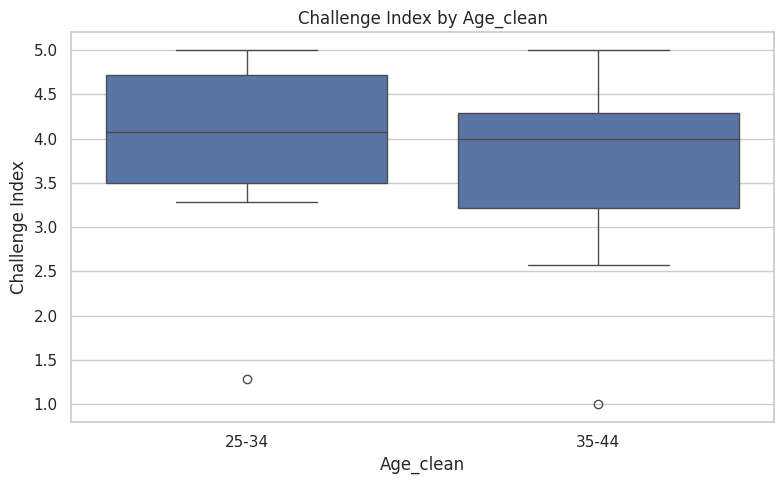

ANOVA for Education_Level not significant (p = 0.9657)


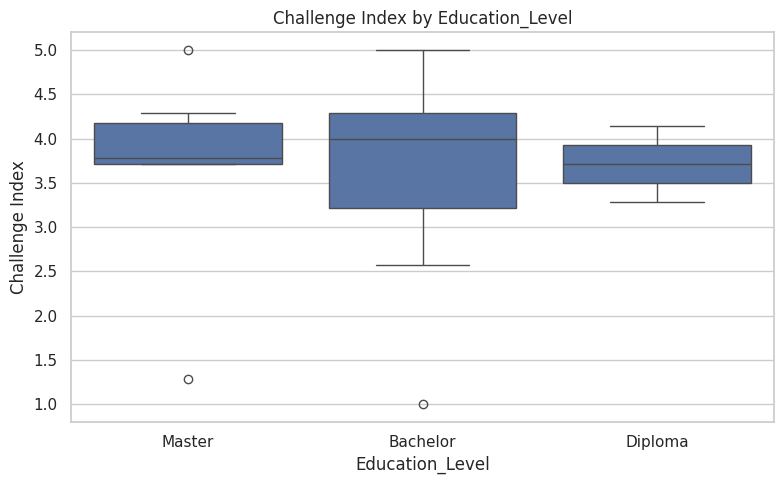

ANOVA for Working_Experience not significant (p = 0.9446)


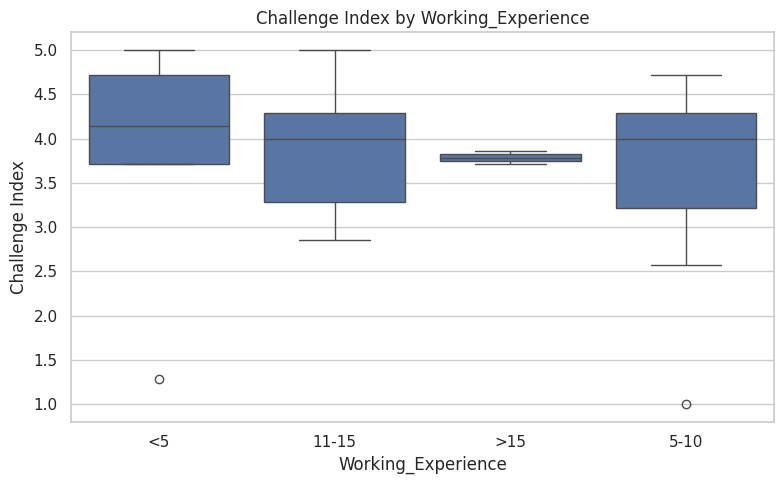

Group stats saved to pepmis_group_stats.csv
Inferential results written to pepmis_inferential_results.txt
Done.


In [ ]:
#!/usr/bin/env python3
"""
Inferential analysis for PEPMIS Challenge Index.

What this script does (plain and simple):
- Loads the data file that includes the Challenge_Index:
    drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified_cleaned_with_index.csv
- Runs these tests:
    - Sex: Independent samples t-test (Welch's t-test)
    - Age group: One-way ANOVA (with Tukey post-hoc if p < 0.05)
    - Education level: One-way ANOVA (with Tukey post-hoc if p < 0.05)
    - Working experience: One-way ANOVA (with Tukey post-hoc if p < 0.05)
- Decision rule: p < 0.05 → difference is statistically significant
- Saves plain-language summaries and numeric results to files and prints the main conclusions.
- Saves simple boxplots for each grouping variable.

Files created:
- pepmis_group_stats.csv         (mean, sd, n per group for each variable)
- pepmis_inferential_results.txt (plain-language results + p-values)
- pepmis_tukey_<var>.csv        (Tukey HSD results for var when significant)
- boxplot_<var>.png             (boxplot of Challenge_Index by group for each var)

How to run:
- Put this file next to your data file or edit INPUT path below.
- Run: python analysis_inferential_pepmis.py
"""
from pathlib import Path
import sys
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# statsmodels for ANOVA and Tukey
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Input: the CSV created earlier that includes Challenge_Index
INPUT = Path("drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified_cleaned_with_index.csv")

# Output files
GROUP_STATS_CSV = Path("pepmis_group_stats.csv")
INFER_RESULTS_TXT = Path("pepmis_inferential_results.txt")
PLOT_DIR = Path(".")  # plots saved in current folder

# Grouping variables to test
GROUP_VARS = {
    "Sex": "Sex",
    "Age": "Age_clean",
    "Education_Level": "Education_Level",
    "Working_Experience": "Working_Experience"
}

CHALLENGE_COL = "Challenge_Index"

# Small helpers
def load_data(path):
    if not path.exists():
        print(f"Input file not found: {path}", file=sys.stderr)
        sys.exit(1)
    df = pd.read_csv(path, parse_dates=["Timestamp"], dayfirst=True, keep_default_na=True)
    return df

def summarize_groups(df, group_col):
    """Return a DataFrame with n, mean, sd for each group in group_col."""
    s = df[[group_col, CHALLENGE_COL]].copy()
    s[CHALLENGE_COL] = pd.to_numeric(s[CHALLENGE_COL], errors="coerce")
    grp = s.groupby(group_col)[CHALLENGE_COL].agg(['count', 'mean', 'std']).reset_index()
    grp = grp.rename(columns={'count':'n', 'std':'sd', 'mean':'mean'})
    # round numbers for readability
    grp['mean'] = grp['mean'].round(3)
    grp['sd'] = grp['sd'].round(3)
    return grp

def run_ttest_sex(df, group_col):
    """Run Welch's t-test for two groups (e.g., Male vs Female)."""
    out = {}
    s = df[[group_col, CHALLENGE_COL]].copy()
    s[CHALLENGE_COL] = pd.to_numeric(s[CHALLENGE_COL], errors="coerce")
    groups = s[group_col].dropna().unique()
    groups = [g for g in groups if pd.notna(g)]
    if len(groups) != 2:
        out['skipped'] = True
        out['reason'] = f"Need exactly 2 groups for t-test; found {len(groups)}: {groups}"
        return out
    g1, g2 = groups
    data1 = s[s[group_col] == g1][CHALLENGE_COL].dropna()
    data2 = s[s[group_col] == g2][CHALLENGE_COL].dropna()
    out['skipped'] = False
    out['group_labels'] = (g1, g2)
    out['n1'] = int(data1.count())
    out['n2'] = int(data2.count())
    if out['n1'] < 2 or out['n2'] < 2:
        out['warning'] = "Small sample size in one or both groups; interpret p-value cautiously."
    # Welch's t-test
    tstat, pval = stats.ttest_ind(data1, data2, equal_var=False, nan_policy='omit')
    out['tstat'] = float(tstat) if not np.isnan(tstat) else None
    out['pval'] = float(pval) if not np.isnan(pval) else None
    out['mean1'] = float(data1.mean()) if data1.count() > 0 else np.nan
    out['mean2'] = float(data2.mean()) if data2.count() > 0 else np.nan
    return out

def run_anova(df, group_col):
    """Run one-way ANOVA using statsmodels. Returns ANOVA table and p-value."""
    out = {}
    if group_col not in df.columns:
        out['skipped'] = True
        out['reason'] = f"Column {group_col} not in data"
        return out
    s = df[[group_col, CHALLENGE_COL]].copy()
    s = s.dropna(subset=[group_col, CHALLENGE_COL])
    # Need at least 2 groups and total at least 2 observations
    groups = s[group_col].unique()
    if len(groups) < 2:
        out['skipped'] = True
        out['reason'] = f"Need at least 2 groups for ANOVA; found {len(groups)}"
        return out
    # Fit ANOVA model
    formula = f"{CHALLENGE_COL} ~ C({group_col})"
    try:
        model = ols(formula, data=s).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        pval = float(anova_table["PR(>F)"].iloc[0])
        out['skipped'] = False
        out['anova_table'] = anova_table
        out['pval'] = pval
        out['model'] = model
        out['groups_present'] = list(groups)
        return out
    except Exception as e:
        out['skipped'] = True
        out['reason'] = f"ANOVA failed: {e}"
        return out

def run_tukey(df, group_col):
    """Run Tukey HSD post-hoc test and return a DataFrame of results."""
    s = df[[group_col, CHALLENGE_COL]].copy()
    s = s.dropna(subset=[group_col, CHALLENGE_COL])
    s[CHALLENGE_COL] = pd.to_numeric(s[CHALLENGE_COL], errors="coerce")
    # Tukey requires at least two groups and some observations
    if s[group_col].nunique() < 2:
        return None
    try:
        tuk = pairwise_tukeyhsd(endog=s[CHALLENGE_COL], groups=s[group_col], alpha=0.05)
        # Convert to DataFrame
        res_df = pd.DataFrame(data=tuk._results_table.data[1:], columns=tuk._results_table.data[0])
        return res_df
    except Exception:
        return None

def save_boxplot(df, group_col):
    outfile = PLOT_DIR / f"boxplot_{group_col}.png"
    if group_col not in df.columns:
        return None
    s = df[[group_col, CHALLENGE_COL]].copy()
    s = s.dropna(subset=[group_col, CHALLENGE_COL])
    if s.empty:
        return None
    plt.figure(figsize=(8,5))
    # Use seaborn boxplot; avoid passing palette-only in a way that triggers warnings
    sns.boxplot(x=group_col, y=CHALLENGE_COL, data=s)
    plt.title(f"Challenge Index by {group_col}")
    plt.xlabel(group_col)
    plt.ylabel("Challenge Index")
    plt.tight_layout()
    plt.savefig(outfile, dpi=150)
    plt.show()
    plt.close()
    return outfile

def main():
    df = load_data(INPUT)

    # Check Challenge_Index exists and is numeric
    if CHALLENGE_COL not in df.columns:
        print(f"{CHALLENGE_COL} not found in data. Please run the index construction step first.", file=sys.stderr)
        sys.exit(1)
    df[CHALLENGE_COL] = pd.to_numeric(df[CHALLENGE_COL], errors="coerce")

    # Prepare CSV to collect group stats for all group vars
    all_group_stats = []

    # Open results text file for plain-language reporting
    with open(INFER_RESULTS_TXT, "w", encoding="utf-8") as fout:
        fout.write("Inferential analysis results for Challenge_Index\n")
        fout.write("Decision rule: p < 0.05 indicates a statistically significant difference\n\n")

        # 1) Sex: t-test (only if exactly two groups)
        group_col = GROUP_VARS["Sex"]
        fout.write("1) Sex (t-test)\n")
        if group_col in df.columns:
            grp_stats = summarize_groups(df, group_col)
            all_group_stats.append((group_col, grp_stats))
            fout.write(grp_stats.to_string(index=False))
            fout.write("\n\n")
            tres = run_ttest_sex(df, group_col)
            if tres.get('skipped', False):
                fout.write(f"t-test skipped: {tres.get('reason')}\n\n")
                print(f"Sex test skipped: {tres.get('reason')}")
            else:
                fout.write(f"Groups: {tres['group_labels'][0]} (n={tres['n1']}) vs {tres['group_labels'][1]} (n={tres['n2']})\n")
                fout.write(f"Means: {tres['mean1']:.3f} vs {tres['mean2']:.3f}\n")
                fout.write(f"t-statistic = {tres['tstat']:.3f}, p-value = {tres['pval']:.4f}\n")
                if 'warning' in tres:
                    fout.write("Warning: small sample size in one or both groups; interpret cautiously.\n")
                if tres['pval'] < 0.05:
                    fout.write("Conclusion: The difference between sexes is statistically significant (p < 0.05).\n\n")
                else:
                    fout.write("Conclusion: No statistically significant difference between sexes (p >= 0.05).\n\n")
                print(f"Sex t-test p = {tres['pval']:.4f}")
        else:
            fout.write(f"Column {group_col} not found in data.\n\n")
            print(f"Sex column {group_col} not found.")

        # For each ANOVA grouping variable
        anova_vars = ["Age", "Education_Level", "Working_Experience"]
        for key in anova_vars:
            group_col = GROUP_VARS.get(key, key)
            fout.write(f"{key} (one-way ANOVA)\n")
            if group_col not in df.columns:
                fout.write(f"Column {group_col} not found in data.\n\n")
                print(f"{group_col} not in data; skipping ANOVA for {key}.")
                continue

            # Group stats
            grp_stats = summarize_groups(df, group_col)
            all_group_stats.append((group_col, grp_stats))
            fout.write(grp_stats.to_string(index=False))
            fout.write("\n\n")

            anova_res = run_anova(df, group_col)
            if anova_res.get('skipped', False):
                fout.write(f"ANOVA skipped: {anova_res.get('reason')}\n\n")
                print(f"ANOVA skipped for {group_col}: {anova_res.get('reason')}")
                continue

            # Write ANOVA table
            fout.write("ANOVA table:\n")
            fout.write(anova_res['anova_table'].to_string())
            fout.write("\n\n")
            pval = anova_res['pval']
            fout.write(f"p-value = {pval:.4f}\n")
            if pval < 0.05:
                fout.write("Conclusion: There is a statistically significant difference between groups (p < 0.05).\n")
                # run Tukey HSD
                tukey_df = run_tukey(df, group_col)
                if tukey_df is not None:
                    tukey_out = Path(f"pepmis_tukey_{group_col}.csv")
                    tukey_df.to_csv(tukey_out, index=False)
                    fout.write(f"Tukey HSD results saved to {tukey_out}\n")
                    fout.write(tukey_df.to_string(index=False))
                    fout.write("\n\n")
                    print(f"Tukey test done for {group_col}, saved to {tukey_out}")
                else:
                    fout.write("Tukey HSD could not be computed or returned no results.\n\n")
                    print(f"Tukey HSD not available for {group_col}")
            else:
                fout.write("Conclusion: No statistically significant difference between groups (p >= 0.05).\n\n")
                print(f"ANOVA for {group_col} not significant (p = {pval:.4f})")

            # Save boxplot for this group
            plotfile = save_boxplot(df, group_col)
            if plotfile:
                fout.write(f"Boxplot saved to: {plotfile}\n\n")
            else:
                fout.write("Boxplot not created (no data or column missing).\n\n")

        # After looping groups, save combined group stats to CSV for reference
        # We'll concat all group stats with an extra column indicating which grouping variable
        combined_rows = []
        for group_col, gdf in all_group_stats:
            tmp = gdf.copy()
            tmp['group_var'] = group_col
            combined_rows.append(tmp)
        if combined_rows:
            combined = pd.concat(combined_rows, ignore_index=True, sort=False)
            combined.to_csv(GROUP_STATS_CSV, index=False)
            fout.write(f"Group means and counts saved to {GROUP_STATS_CSV}\n")
            print(f"Group stats saved to {GROUP_STATS_CSV}")

    print(f"Inferential results written to {INFER_RESULTS_TXT}")
    print("Done.")

if __name__ == "__main__":
    main()

The independent-samples t-test conducted by sex produced a p-value of 0.3559, indicating no statistically significant difference in the mean Challenge Index between male and female teachers. Similarly, the one-way ANOVA tests for age groups (p = 0.7260), education level (p = 0.9657), and working experience (p = 0.9446) all showed no statistically significant differences in mean Challenge Index scores across their respective categories. These results demonstrate that variations in perceived PEPMIS challenges are not associated with these demographic or professional characteristics within the study sample.

<!-- Implications of the Findings -->

The findings indicate that teachers, regardless of sex, age, educational background, or years of experience, report broadly similar levels of challenge in relation to PEPMIS. Using the conventional significance threshold of p < 0.05, there is no statistical evidence to support the presence of group-based differences. This suggests that the challenges linked to PEPMIS are systemic rather than confined to specific subgroups of teachers.

<!-- Practical Implications for Action -->

Interventions should be designed as system-wide measures rather than being targeted at specific demographic or experience-based groups. Since challenges appear uniform across categories, policies should focus on structural issues such as training provision, technical support, and ICT infrastructure. Further diagnostic analysis should focus on institutional and contextual factors (such as school location, ICT availability, and administrative support) rather than teacher characteristics.

### Visualisation


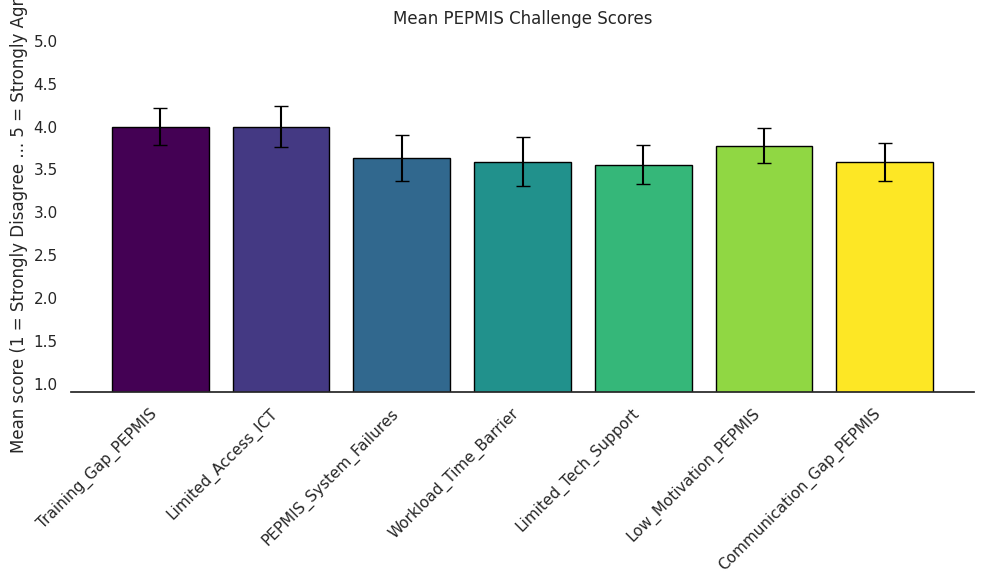

Saved mean scores bar chart to: mean_challenge_scores.png


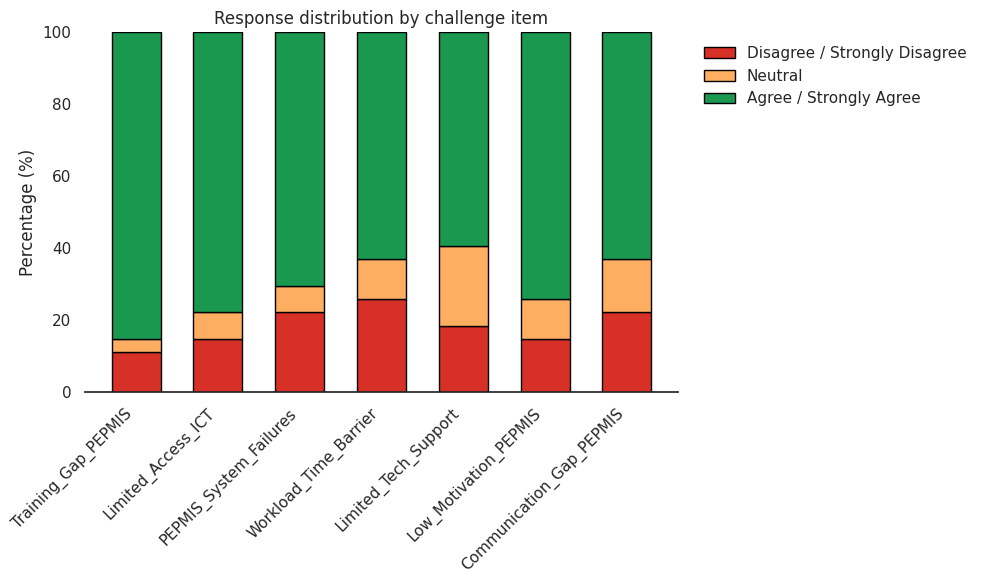

Saved stacked percent chart to: stacked_response_distribution.png


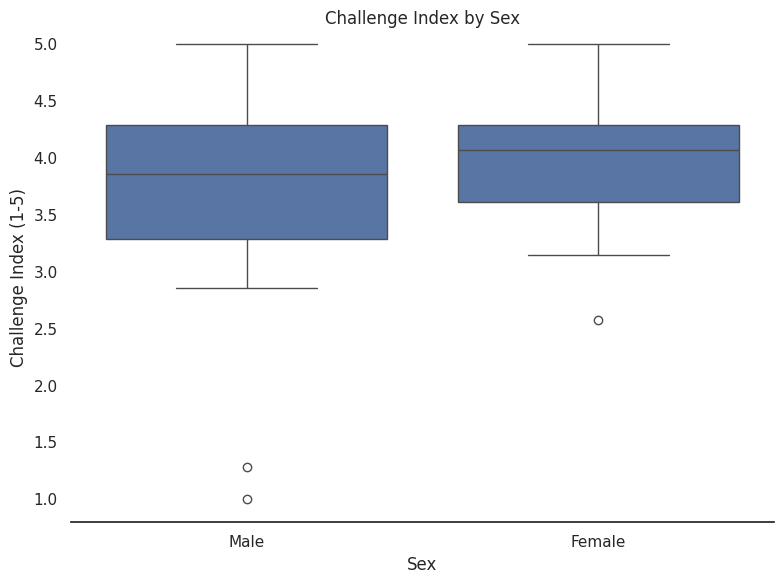

Saved boxplot for Sex to: boxplot_Sex.png


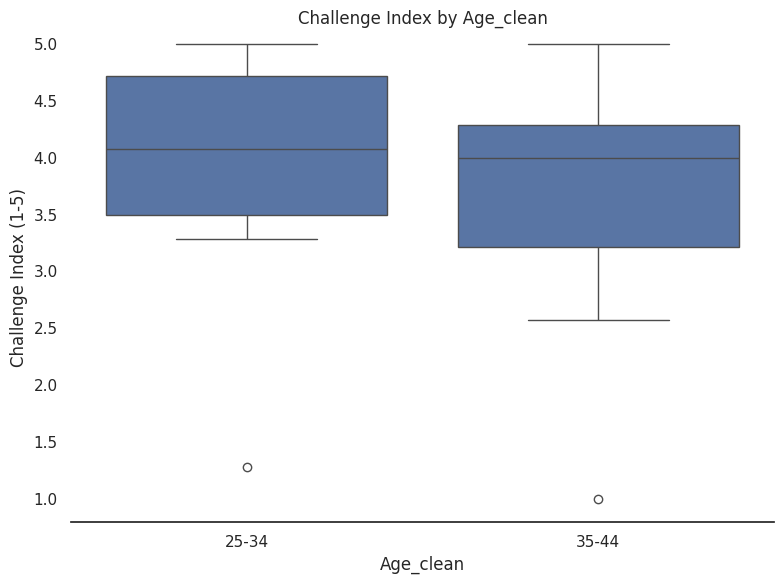

Saved boxplot for Age_clean to: boxplot_Age_clean.png


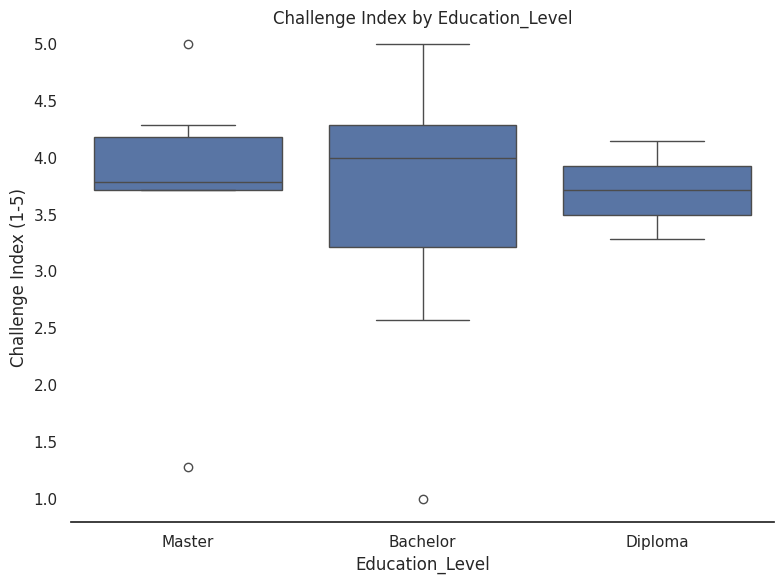

Saved boxplot for Education_Level to: boxplot_Education_Level.png


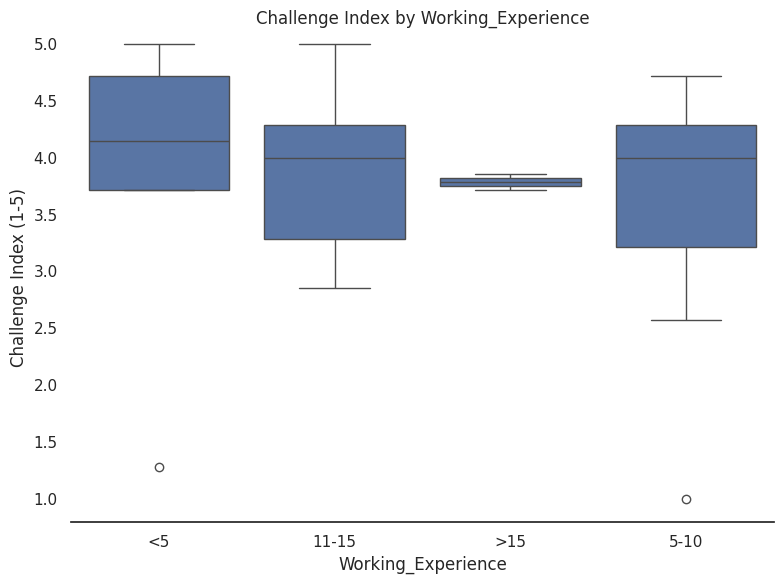

Saved boxplot for Working_Experience to: boxplot_Working_Experience.png


In [ ]:
#!/usr/bin/env python3
"""
Create three types of clear plots for the PEPMIS data.

Inputs:
 - drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified_cleaned_with_index.csv

Outputs (saved in current folder):
 - mean_challenge_scores.png
 - stacked_response_distribution.png  (legend at top-right, outside plot)
 - boxplot_<group>.png

Notes:
 - Plots do not show grid lines, as requested.
 - The stacked-percent chart legend is placed at the top-right outside the plot area.
"""
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Input file (change if needed)
INPUT = Path("drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified_cleaned_with_index.csv")

# Output filenames
OUT_MEAN = Path("mean_challenge_scores.png")
OUT_STACKED = Path("stacked_response_distribution.png")
OUT_BOXPLOT_TEMPLATE = "boxplot_{}.png"  # fill with group name

# The 7 Likert items
LIKERT_COLUMNS = [
    "Training_Gap_PEPMIS",
    "Limited_Access_ICT",
    "PEPMIS_System_Failures",
    "Workload_Time_Barrier",
    "Limited_Tech_Support",
    "Low_Motivation_PEPMIS",
    "Communication_Gap_PEPMIS",
]

# Groups to plot boxplots for (will skip if missing)
GROUP_VARS = ["Sex", "Age_clean", "Education_Level", "Working_Experience"]

def load_data(path):
    if not path.exists():
        print(f"Input file not found: {path}", file=sys.stderr)
        sys.exit(1)
    df = pd.read_csv(path, parse_dates=["Timestamp"], dayfirst=True, keep_default_na=True)
    return df

def plot_mean_scores(df, items, outpath):
    data = df[items].apply(pd.to_numeric, errors='coerce')
    means = data.mean(skipna=True)
    sems = data.sem(skipna=True)
    labels = list(items)

    sns.set_style("white")
    plt.figure(figsize=(10,6))
    x = np.arange(len(labels))
    colors = plt.cm.viridis(np.linspace(0,1,len(labels)))
    plt.bar(x, means.values, color=colors, edgecolor='black')
    plt.errorbar(x, means.values, yerr=sems.values, fmt='none', ecolor='black', capsize=5)
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylabel("Mean score (1 = Strongly Disagree ... 5 = Strongly Agree)")
    plt.ylim(0.9, 5.1)
    plt.title("Mean PEPMIS Challenge Scores")
    sns.despine(left=True, bottom=False)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.show()
    plt.close()
    print(f"Saved mean scores bar chart to: {outpath}")

def plot_stacked_percent(df, items, outpath):
    bands = {"Disagree_or_SD": [], "Neutral": [], "Agree_or_SA": []}
    labels = []
    for col in items:
        s = pd.to_numeric(df[col], errors='coerce').dropna().astype(int)
        total = len(s)
        if total == 0:
            d = n = a = 0.0
        else:
            d = (s <= 2).sum() / total * 100.0
            n = (s == 3).sum() / total * 100.0
            a = (s >= 4).sum() / total * 100.0
        bands["Disagree_or_SD"].append(d)
        bands["Neutral"].append(n)
        bands["Agree_or_SA"].append(a)
        labels.append(col)

    sns.set_style("white")
    plt.figure(figsize=(10,6))
    x = np.arange(len(labels))
    width = 0.6
    colors = ["#d73027", "#fdae61", "#1a9850"]  # red, orange, green
    p1 = plt.bar(x, bands["Disagree_or_SD"], width, color=colors[0], edgecolor='black')
    p2 = plt.bar(x, bands["Neutral"], width, bottom=bands["Disagree_or_SD"], color=colors[1], edgecolor='black')
    bottom2 = np.array(bands["Disagree_or_SD"]) + np.array(bands["Neutral"])
    p3 = plt.bar(x, bands["Agree_or_SA"], width, bottom=bottom2, color=colors[2], edgecolor='black')
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylabel("Percentage (%)")
    plt.ylim(0, 100)
    plt.title("Response distribution by challenge item")

    # Place legend at top-right outside the plot area
    handles = [p1[0], p2[0], p3[0]]
    labels_leg = ["Disagree / Strongly Disagree", "Neutral", "Agree / Strongly Agree"]
    # make room on the right for the legend
    plt.subplots_adjust(right=0.7)
    plt.legend(handles, labels_leg, loc='upper left', bbox_to_anchor=(1.02, 1.0),
               ncol=1, frameon=False, fontsize=11)

    sns.despine(left=True, bottom=False)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(outpath, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved stacked percent chart to: {outpath}")

def plot_boxplots_by_groups(df, group_vars, out_template):
    sns.set_style("white")
    for g in group_vars:
        if g not in df.columns:
            print(f"Skipping boxplot for {g}: column not found.")
            continue
        s = df[[g, "Challenge_Index"]].dropna(subset=[g, "Challenge_Index"]).copy()
        if s.empty:
            print(f"Skipping boxplot for {g}: no data after dropping missing.")
            continue
        plt.figure(figsize=(8,6))
        sns.boxplot(x=g, y="Challenge_Index", data=s)
        plt.xlabel(g)
        plt.ylabel("Challenge Index (1-5)")
        plt.ylim(0.8, 5.1)
        plt.title(f"Challenge Index by {g}")
        sns.despine(left=True, bottom=False)
        plt.grid(False)
        plt.tight_layout()
        outpath = Path(out_template.format(g))
        plt.savefig(outpath, dpi=150)
        plt.show()
        plt.close()
        print(f"Saved boxplot for {g} to: {outpath}")

def main():
    df = load_data(INPUT)

    missing = [c for c in LIKERT_COLUMNS if c not in df.columns]
    if missing:
        print("Warning: some Likert columns are missing and will be skipped:", missing)

    present_items = [c for c in LIKERT_COLUMNS if c in df.columns]
    if not present_items:
        print("No Likert items found. Exiting.", file=sys.stderr)
        sys.exit(1)

    if "Challenge_Index" not in df.columns:
        print("Warning: Challenge_Index not found. Boxplots by group that use it will be skipped.", file=sys.stderr)

    plot_mean_scores(df, present_items, OUT_MEAN)
    plot_stacked_percent(df, present_items, OUT_STACKED)
    plot_boxplots_by_groups(df, GROUP_VARS, OUT_BOXPLOT_TEMPLATE)

if __name__ == "__main__":
    main()

# Alternative Data Analysis Approaches

**a) Exploratory Factor Analysis (EFA):**

 Use when we want to check whether the challenges cluster into themes (e.g., “technical issues”, “human factors”).


In [ ]:
!pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=b967f421f5916ecdbfa4f70bc9bbcce694669b1ebb72b3fb5a34deb68e50eff3
  Stored in directory: /root/.cache/pip/wheels/a2/af/06/f4d4ed4d9d714fda437fb1583629417319603c2266e7b233cc
Successfully built factor_analyzer


Using 27 respondents and 7 items for EFA.
KMO overall: 0.827
KMO per item:
  Training_Gap_PEPMIS: 0.862
  Limited_Access_ICT: 0.871
  PEPMIS_System_Failures: 0.81
  Workload_Time_Barrier: 0.782
  Limited_Tech_Support: 0.848
  Low_Motivation_PEPMIS: 0.778
  Communication_Gap_PEPMIS: 0.822
Bartlett's test: chi-square = 100.726, p = 0.0000
Eigenvalues (desc): [4.391 0.805 0.633 0.497 0.268 0.228 0.179]
Suggested number of factors by eigenvalues > 1 rule: 1


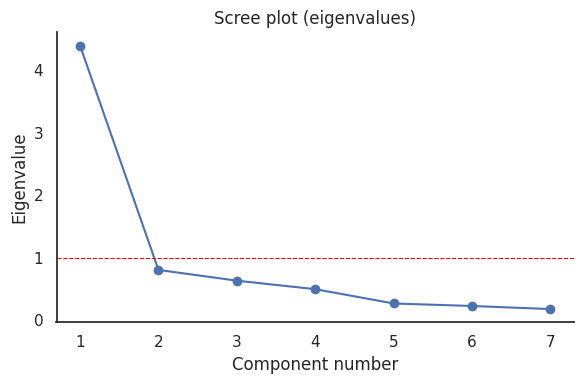

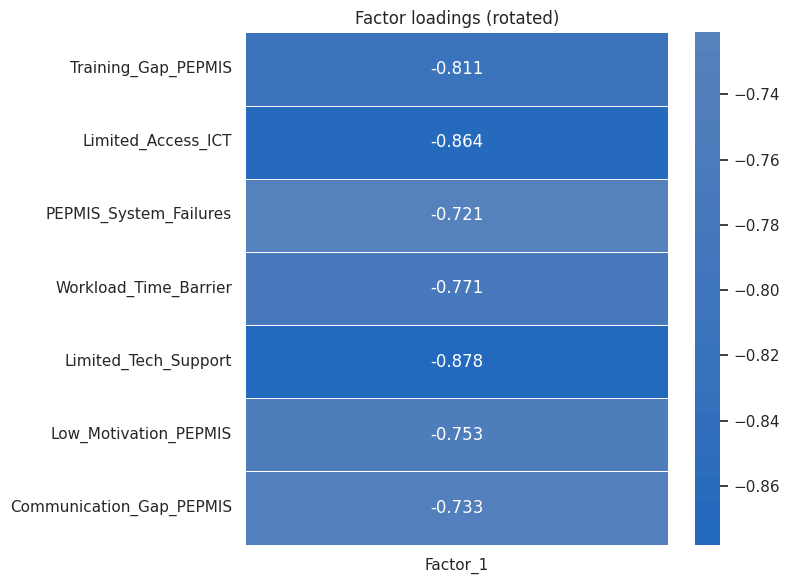

Saved: efa_eigenvalues.csv, efa_loadings.csv, efa_communalities.csv, efa_factor_variance.csv
Saved plots: efa_scree.png, efa_loadings_heatmap.png

Factor loadings (rounded):
                          Factor_1
Training_Gap_PEPMIS         -0.811
Limited_Access_ICT          -0.864
PEPMIS_System_Failures      -0.721
Workload_Time_Barrier       -0.771
Limited_Tech_Support        -0.878
Low_Motivation_PEPMIS       -0.753
Communication_Gap_PEPMIS    -0.733

Communalities:
                    item  communality
     Training_Gap_PEPMIS     0.657050
      Limited_Access_ICT     0.745931
  PEPMIS_System_Failures     0.520151
   Workload_Time_Barrier     0.594318
    Limited_Tech_Support     0.770043
   Low_Motivation_PEPMIS     0.566714
Communication_Gap_PEPMIS     0.536722

Variance explained by factors:
  Factor  Eigenvalue_or_variance  Proportion_variance  Cumulative_variance
Factor_1                   4.391                0.627                0.627

Plain suggestions:
 - Look for loadings >= 

In [ ]:
#!/usr/bin/env python3
"""
Exploratory Factor Analysis (EFA) for PEPMIS challenge items.

Changes made to handle warnings:
 - Suppress the sklearn FutureWarning about 'force_all_finite' used internally.
 - If number of factors == 1, do not request rotation (avoids factor_analyzer UserWarning).

Usage:
  python efa_pepmis.py [--n-factors N] [--impute]

If you run this in a notebook, the script ignores notebook kernel args.
If factor_analyzer is missing, install it with:
  pip install factor_analyzer
"""
from pathlib import Path
import sys
import argparse
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress a narrow sklearn/factor_analyzer FutureWarning that appears in some installs.
# This targets messages that mention 'force_all_finite' to avoid hiding other FutureWarnings.
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*force_all_finite.*"
)

# Input file - change if your file is elsewhere
INPUT = Path("drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified_cleaned_with_index.csv")

LIKERT_COLUMNS = [
    "Training_Gap_PEPMIS",
    "Limited_Access_ICT",
    "PEPMIS_System_Failures",
    "Workload_Time_Barrier",
    "Limited_Tech_Support",
    "Low_Motivation_PEPMIS",
    "Communication_Gap_PEPMIS",
]

# Try to import FactorAnalyzer; if missing, ask user to install.
try:
    from factor_analyzer import FactorAnalyzer
except Exception:
    print("\nMissing package 'factor_analyzer'. Install it with:")
    print("  pip install factor_analyzer\n")
    sys.exit(1)

# We will compute KMO and Bartlett here to avoid import issues.
from scipy import stats

def load_data(path, items):
    if not path.exists():
        print(f"Input file not found: {path}", file=sys.stderr)
        sys.exit(1)
    df = pd.read_csv(path, parse_dates=["Timestamp"], dayfirst=True, keep_default_na=True)
    missing = [c for c in items if c not in df.columns]
    present = [c for c in items if c in df.columns]
    if missing:
        print("Warning: these expected Likert columns are missing and will be skipped:", missing)
    return df, present

def prepare_matrix(df, cols, impute=False):
    data = df[cols].apply(pd.to_numeric, errors='coerce')
    n_before = len(data)
    if impute:
        data = data.fillna(data.mean())
        print("Missing values filled by column mean (impute=True).")
    else:
        data = data.dropna(axis=0, how='any')
        dropped = n_before - len(data)
        if dropped > 0:
            print(f"Dropped {dropped} rows with missing values for the items (impute=False).")
    return data

def compute_kmo(df):
    """
    Compute KMO overall and per-variable.
    Uses correlations and partial correlations derived from the inverse correlation matrix.
    Returns overall_kmo, kmo_per_variable (dict).
    """
    corr = df.corr().values
    try:
        inv_corr = np.linalg.inv(corr)
    except np.linalg.LinAlgError:
        eps = 1e-6
        inv_corr = np.linalg.inv(corr + np.eye(corr.shape[0]) * eps)

    denom = np.sqrt(np.outer(np.diag(inv_corr), np.diag(inv_corr)))
    partial = -inv_corr / denom
    np.fill_diagonal(partial, 0.0)

    p = corr.shape[0]
    sum_r2 = 0.0
    sum_p2 = 0.0
    kmo_per_var = {}
    for i in range(p):
        r2_i = 0.0
        p2_i = 0.0
        for j in range(p):
            if i == j:
                continue
            r2 = corr[i, j] ** 2
            p2 = partial[i, j] ** 2
            r2_i += r2
            p2_i += p2
            sum_r2 += r2
            sum_p2 += p2
        denom_i = r2_i + p2_i
        kmo_per_var[i] = (r2_i / denom_i) if denom_i != 0 else np.nan

    overall_kmo = sum_r2 / (sum_r2 + sum_p2) if (sum_r2 + sum_p2) != 0 else np.nan
    return overall_kmo, kmo_per_var

def bartlett_sphericity(df):
    """
    Bartlett's test of sphericity:
    chi2 = -(n-1 - (2p+5)/6) * ln(det(R))
    df = p*(p-1)/2
    Returns chi2_stat, p_value
    """
    n, p = df.shape
    R = df.corr().values
    sign, logdet = np.linalg.slogdet(R)
    if sign <= 0:
        return np.nan, np.nan
    chi2 = -(n - 1 - (2 * p + 5) / 6.0) * logdet
    df_deg = p * (p - 1) / 2
    p_value = stats.chi2.sf(chi2, df_deg)
    return float(chi2), float(p_value)

def compute_eigenvalues(df):
    corr = df.corr().values
    eigvals, _ = np.linalg.eig(corr)
    eigvals = np.real(eigvals)
    eigvals_sorted = np.sort(eigvals)[::-1]
    return eigvals_sorted

def run_efa(data, n_factors):
    """
    When only 1 factor is requested, request rotation=None to avoid a factor_analyzer
    warning about rotation with a single factor.
    """
    if n_factors == 1:
        fa = FactorAnalyzer(n_factors=n_factors, rotation=None, method='principal')
    else:
        fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax', method='principal')
    fa.fit(data)
    loadings = fa.loadings_
    communalities = fa.get_communalities()
    var, prop_var, cum_var = fa.get_factor_variance()
    return fa, loadings, communalities, (var, prop_var, cum_var)

def save_and_plot_results(cols, eigvals, loadings, communalities, var_tuple):
    eig_df = pd.DataFrame({
        "factor_number": np.arange(1, len(eigvals)+1),
        "eigenvalue": eigvals
    })
    eig_df.to_csv("efa_eigenvalues.csv", index=False)
    load_df = pd.DataFrame(loadings, index=cols)
    load_df.columns = [f"Factor_{i+1}" for i in range(load_df.shape[1])]
    load_df.to_csv("efa_loadings.csv")
    comm_df = pd.DataFrame({"item": cols, "communality": communalities})
    comm_df.to_csv("efa_communalities.csv", index=False)
    var_df = pd.DataFrame({
        "eigenvalue_or_variance": var_tuple[0],
        "proportion_variance": var_tuple[1],
        "cumulative_variance": var_tuple[2]
    })
    var_df.index = [f"Factor_{i+1}" for i in range(var_df.shape[0])]
    var_df.to_csv("efa_factor_variance.csv")

    plt.figure(figsize=(6,4))
    x = np.arange(1, len(eigvals)+1)
    plt.plot(x, eigvals, marker='o', linestyle='-')
    plt.axhline(1.0, color='red', linestyle='--', linewidth=0.8)
    plt.xticks(x)
    plt.xlabel("Component number")
    plt.ylabel("Eigenvalue")
    plt.title("Scree plot (eigenvalues)")
    sns.despine()
    plt.tight_layout()
    plt.savefig("efa_scree.png", dpi=150)
    plt.show()
    plt.close()




    load_df_annot = load_df.round(3)
    plt.figure(figsize=(8,6))
    sns.heatmap(load_df_annot, annot=True, cmap="vlag", center=0, linewidths=0.5, fmt=".3f")
    plt.title("Factor loadings (rotated)")
    plt.tight_layout()
    plt.savefig("efa_loadings_heatmap.png", dpi=150)
    plt.show()
    plt.close()

    print("Saved: efa_eigenvalues.csv, efa_loadings.csv, efa_communalities.csv, efa_factor_variance.csv")
    print("Saved plots: efa_scree.png, efa_loadings_heatmap.png")

def main(argv=None):
    parser = argparse.ArgumentParser(description="Run EFA on PEPMIS Likert items.")
    parser.add_argument("--n-factors", type=int, default=None, help="Number of factors to extract.")
    parser.add_argument("--impute", action="store_true", help="Fill missing item values with column mean.")
    if argv is None:
        args, _ = parser.parse_known_args()
    else:
        args = parser.parse_args(argv)

    df, present = load_data(INPUT, LIKERT_COLUMNS)
    if not present:
        print("No Likert items found. Exiting.", file=sys.stderr)
        sys.exit(1)

    data = prepare_matrix(df, present, impute=args.impute)
    n_rows, n_vars = data.shape
    print(f"Using {n_rows} respondents and {n_vars} items for EFA.")

    if n_rows < 5:
        print("Warning: very small sample size for EFA (less than 5 rows). Results may be unstable.")

    try:
        overall_kmo, kmo_per_var = compute_kmo(data)
        kmo_named = {data.columns[i]: round(kmo_per_var.get(i, np.nan), 3) for i in range(len(data.columns))}
        print(f"KMO overall: {round(overall_kmo,3)}")
        print("KMO per item:")
        for k, v in kmo_named.items():
            print(f"  {k}: {v}")
    except Exception as e:
        print("KMO computation failed:", e)

    try:
        chi2, pval = bartlett_sphericity(data)
        if np.isnan(chi2):
            print("Bartlett test could not be computed (non-positive determinant).")
        else:
            print(f"Bartlett's test: chi-square = {chi2:.3f}, p = {pval:.4f}")
    except Exception as e:
        print("Bartlett test failed:", e)

    eigvals = compute_eigenvalues(data)
    print("Eigenvalues (desc):", np.round(eigvals, 3))

    if args.n_factors is not None:
        n_factors = args.n_factors
        print(f"Number of factors forced to {n_factors} by user.")
    else:
        n_factors = int((eigvals > 1.0).sum())
        if n_factors < 1:
            n_factors = 1
        print(f"Suggested number of factors by eigenvalues > 1 rule: {n_factors}")

    try:
        fa, loadings, communalities, var_tuple = run_efa(data, n_factors)
        save_and_plot_results(list(data.columns), eigvals, loadings, communalities, var_tuple)

        load_df = pd.DataFrame(loadings, index=list(data.columns),
                               columns=[f"Factor_{i+1}" for i in range(loadings.shape[1])])
        print("\nFactor loadings (rounded):")
        print(load_df.round(3).to_string())
        comm_df = pd.DataFrame({"item": list(data.columns), "communality": communalities})
        print("\nCommunalities:")
        print(comm_df.to_string(index=False))

        var_df = pd.DataFrame({
            "Factor": [f"Factor_{i+1}" for i in range(len(var_tuple[0]))],
            "Eigenvalue_or_variance": var_tuple[0],
            "Proportion_variance": var_tuple[1],
            "Cumulative_variance": var_tuple[2]
        })
        print("\nVariance explained by factors:")
        print(var_df.round(3).to_string(index=False))

        print("\nPlain suggestions:")
        print(" - Look for loadings >= 0.4 (or <= -0.4) to see which items group under each factor.")
        print(" - If items cluster into 'technical' vs 'human' themes, label factors accordingly in your report.")
    except Exception as e:
        print("EFA failed:", e)
        sys.exit(1)

if __name__ == "__main__":
    main()

<!-- Suitability of the Data for Factor Analysis -->

The overall Kaiser–Meyer–Olkin (KMO) measure of sampling adequacy is 0.827, which indicates that the data are highly suitable for exploratory factor analysis. All individual item KMO values exceed the acceptable threshold of 0.70, confirming that each item is adequately correlated with the others. Bartlett’s Test of Sphericity is statistically significant (χ² = 100.726, p < 0.001), indicating that the correlation matrix is not an identity matrix and that meaningful latent factors can be extracted.

<!-- Factor Extraction and Structure -->

Only one factor has an eigenvalue greater than 1 (eigenvalue = 4.391), and this factor alone explains 62.7% of the total variance. This indicates that the seven PEPMIS challenge items reflect a single underlying dimension rather than multiple distinct sub-dimensions. All items load strongly on this single factor, with absolute factor loadings ranging from 0.721 to 0.878. This demonstrates that each item contributes substantially to the same latent construct, interpreted as an overall PEPMIS Challenge Factor.

<!-- Communalities -->

Communality values range from 0.520 to 0.770, showing that between 52% and 77% of the variance in each item is explained by the extracted factor. This confirms that the single-factor model adequately represents all seven indicators.

<!-- Implications of the Findings -->
The results show that training gaps, ICT access, system failures, workload, technical support, motivation, and communication gaps are not separate problem domains but manifestations of one broader, unified PEPMIS challenge construct. This supports the use of a single composite Challenge Index in subsequent analyses and confirms the internal coherence of the measurement scale.

<!-- Practical Implications for Action -->
Interventions should be designed as integrated system-level solutions rather than fragmented actions targeting isolated problems. Since all items load on one factor, improvements in training, ICT infrastructure, technical support, and communication should be implemented in a coordinated manner to achieve meaningful impact.

### Multivariable analysis (regression)

- **Deliverable:** linear regression predicting Challenge_Index from demographics (sex, age, education, experience) and maybe interaction terms.

Fitting model with formula: Challenge_Index ~ C(Sex) + C(Age_clean) + C(Education_Level) + C(Working_Experience)
Education_Level
Diploma    2
Working_Experience
>15    2
Saved coef table to: pepmis_regression_coefs.csv
Saved VIF table to: pepmis_regression_vif.csv
Saved partial R2 table to: pepmis_regression_partialR2.csv
Saved model summary to: pepmis_regression_summary.txt


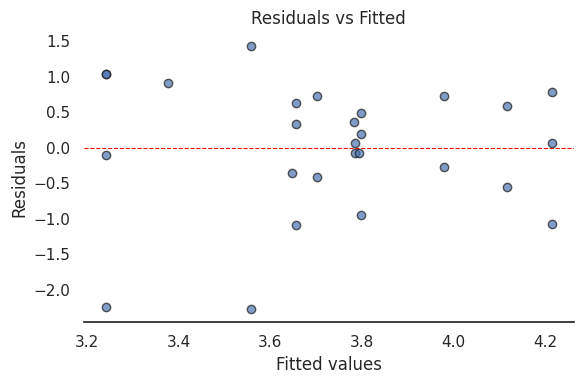

Saved: residuals_vs_fitted.png


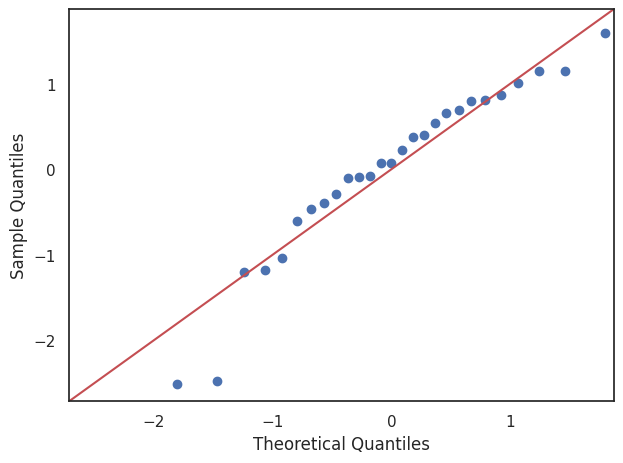

Saved: qqplot_residuals.png


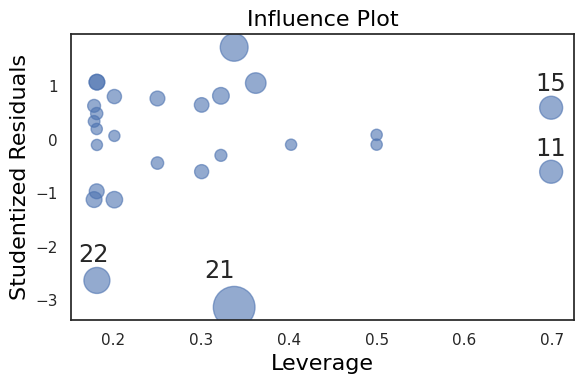

Saved: leverage_cooks.png


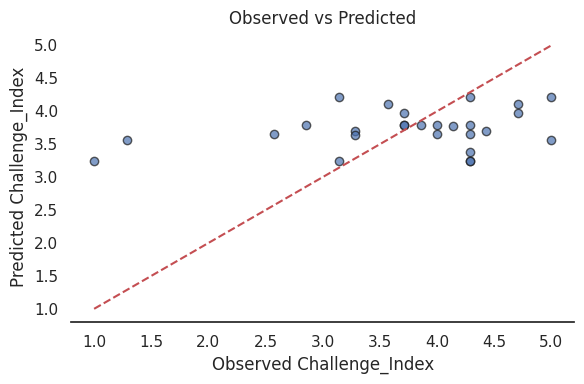

Saved: observed_vs_predicted.png

Plain summary (top-line):
 - Observations: 27
 - R-squared: 0.095
 - Adj. R-squared: -0.238
 - Coefficients (see CSV):
                         term      coef       se       pvalue  ci_lower  ci_upper
                    Intercept  4.676277 0.829134 1.700963e-08  3.051204  6.301349
               C(Sex)[T.Male] -0.416434 0.464898 3.703849e-01 -1.327617  0.494750
        C(Age_clean)[T.35-44] -0.461208 0.645684 4.750454e-01 -1.726725  0.804309
C(Education_Level)[T.Diploma] -0.152153 0.959953 8.740627e-01 -2.033625  1.729320
 C(Education_Level)[T.Master] -0.421648 0.985450 6.687429e-01 -2.353094  1.509798
C(Working_Experience)[T.5-10] -0.558180 0.616358 3.651421e-01 -1.766220  0.649860
  C(Working_Experience)[T.<5] -0.280398 0.952604 7.684910e-01 -2.147468  1.586672
 C(Working_Experience)[T.>15]  0.408513 0.927229 6.595211e-01 -1.408821  2.225848

Done.


In [ ]:
#!/usr/bin/env python3
"""
Multivariable regression predicting Challenge_Index from demographics.

What this script does (plain):
- Loads:
    drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified_cleaned_with_index.csv
  (change INPUT path if your file is elsewhere)
- Encodes demographic predictors as categorical:
    - Sex
    - Age_clean
    - Education_Level
    - Working_Experience
- Fits an OLS linear regression predicting Challenge_Index from those predictors.
  - By default uses main effects only.
  - Optionally include pairwise interactions with --interactions (use with caution on small samples).
- Uses heteroskedasticity-robust standard errors (HC3).
- Computes:
  - Coefficients, p-values, 95% CIs
  - R-squared and adj. R-squared
  - Variance Inflation Factors (VIF) for multicollinearity diagnosis
  - Partial R-squared (effect size) for each grouping variable (group-wise: drop all dummies for that variable)
- Produces diagnostic plots:
  - residuals_vs_fitted.png
  - qqplot_residuals.png
  - leverage_cooks.png
  - observed_vs_predicted.png
- Saves outputs:
  - pepmis_regression_summary.txt  (readable summary)
  - pepmis_regression_coefs.csv    (coefficients, CIs, p-values)
  - pepmis_regression_vif.csv      (VIFs)
  - pepmis_regression_partialR2.csv (partial R2 by group variable)
  - diagnostic plots (PNG files)

Notes on small samples:
- With n=27 you may have limited power and unstable estimates for many dummy columns or interaction terms.
- If a categorical variable has many levels with very small counts, consider collapsing levels before running the regression.

How to run:
- Terminal (recommended): python regression_pepmis.py
- To include interactions: python regression_pepmis.py --interactions
- In a notebook: run the cell; the script will ignore notebook kernel args.

"""
from pathlib import Path
import sys
import argparse
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

# suppress harmless warnings that may come from internals
warnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")

# INPUT path - change if needed
INPUT = Path("drive/MyDrive/Survey_Analysis/QUESTIONNAIRE GUIDES FOR TEACHERS-Form_Modified_cleaned_with_index.csv")

# OUTPUT files
OUT_SUMMARY = Path("pepmis_regression_summary.txt")
OUT_COEFS = Path("pepmis_regression_coefs.csv")
OUT_VIF = Path("pepmis_regression_vif.csv")
OUT_PARTIAL_R2 = Path("pepmis_regression_partialR2.csv")

PLOT_RESID_VS_FIT = Path("residuals_vs_fitted.png")
PLOT_QQ = Path("qqplot_residuals.png")
PLOT_LEVERAGE = Path("leverage_cooks.png")
PLOT_OBS_PRED = Path("observed_vs_predicted.png")

CHALLENGE = "Challenge_Index"
GROUP_VARS = ["Sex", "Age_clean", "Education_Level", "Working_Experience"]

def load_data(path):
    if not path.exists():
        print(f"Input file not found: {path}", file=sys.stderr)
        sys.exit(1)
    df = pd.read_csv(path, parse_dates=["Timestamp"], dayfirst=True, keep_default_na=True)
    return df

def prepare_data(df):
    # Ensure Challenge_Index numeric
    df[CHALLENGE] = pd.to_numeric(df[CHALLENGE], errors="coerce")

    # Convert grouping variables to categorical if present
    present_groups = []
    for g in GROUP_VARS:
        if g in df.columns:
            df[g] = df[g].astype("category")
            present_groups.append(g)
    return df, present_groups

def build_formula(present_groups, include_interactions=False):
    terms = []
    for g in present_groups:
        # use C() in formula to ensure categorical handling
        terms.append(f"C({g})")
    if include_interactions:
        # add pairwise interactions between the grouping variables (only main pairwise)
        interactions = []
        for i in range(len(present_groups)):
            for j in range(i+1, len(present_groups)):
                interactions.append(f"C({present_groups[i]}):C({present_groups[j]})")
        all_terms = terms + interactions
    else:
        all_terms = terms
    if not all_terms:
        formula = f"{CHALLENGE} ~ 1"
    else:
        formula = f"{CHALLENGE} ~ " + " + ".join(all_terms)
    return formula, terms  # return terms (main effects) for partial R2 calc

def fit_model(df, formula):
    # drop rows with missing outcome or all predictors missing (statsmodels handles missing)
    model = ols(formula, data=df).fit(cov_type='HC3')  # robust SEs
    return model

def model_to_coef_df(model):
    params = model.params
    bse = model.bse
    pvalues = model.pvalues
    conf = model.conf_int()
    coef_df = pd.DataFrame({
        "term": params.index,
        "coef": params.values,
        "se": bse.values,
        "pvalue": pvalues.values,
        "ci_lower": conf[0].values,
        "ci_upper": conf[1].values
    })
    return coef_df

def compute_vif(df, formula):
    """
    Compute VIFs using design matrix from patsy via statsmodels dmatrices.
    Exclude intercept.
    """
    from patsy import dmatrices
    y, X = dmatrices(formula, data=df, return_type='dataframe')
    # drop intercept column if present
    if 'Intercept' in X.columns or 'const' in X.columns:
        X = X.loc[:, X.columns.str.lower() != 'intercept']
        X = X.loc[:, X.columns.str.lower() != 'const']
    vif_rows = []
    for i, col in enumerate(X.columns):
        try:
            vif_val = variance_inflation_factor(X.values, i)
        except Exception:
            vif_val = np.nan
        vif_rows.append({"variable": col, "vif": vif_val})
    return pd.DataFrame(vif_rows)

def compute_partial_r2(df, full_formula, main_terms):
    """
    For each main term (C(var)), fit a reduced model without that term (and any interactions involving it)
    and compute partial R2:
      partial_R2 = (R2_full - R2_reduced) / (1 - R2_reduced)
    Use OLS (non-robust) for R2 calculation (statsmodels .rsquared).
    """
    # build list of all terms from the full_formula by splitting (simple approach)
    # We will remove items whose string contains the variable name.
    full_terms = [t.strip() for t in full_formula.split('~')[1].split('+')]
    full_terms = [t for t in full_terms if t != '']
    # fit full model (OLS without robust cov) for R2
    full_mod_ols = ols(full_formula, data=df).fit()
    R2_full = full_mod_ols.rsquared
    results = []
    for term in main_terms:
        # term is like 'C(Sex)'; remove any terms that contain "C(Sex)"
        reduced_terms = [t for t in full_terms if term not in t]
        if reduced_terms:
            reduced_formula = f"{CHALLENGE} ~ " + " + ".join(reduced_terms)
        else:
            reduced_formula = f"{CHALLENGE} ~ 1"
        reduced_mod = ols(reduced_formula, data=df).fit()
        R2_reduced = reduced_mod.rsquared
        # partial R2
        denom = (1 - R2_reduced)
        if denom == 0:
            partial_r2 = np.nan
        else:
            partial_r2 = (R2_full - R2_reduced) / denom
        results.append({"term": term, "R2_full": R2_full, "R2_reduced": R2_reduced, "partial_R2": partial_r2})
    return pd.DataFrame(results)

def save_summary_text(model, coef_df, vif_df, partial_df):
    with open(OUT_SUMMARY, "w", encoding="utf-8") as f:
        f.write("Multivariable regression predicting Challenge_Index\n")
        f.write("Model formula:\n")
        f.write(str(model.model.formula) + "\n\n")
        f.write(f"Observations used: {int(model.nobs)}\n")
        f.write(f"R-squared: {model.rsquared:.3f}\n")
        f.write(f"Adj. R-squared: {model.rsquared_adj:.3f}\n\n")
        f.write("Coefficients (robust SE - HC3):\n")
        f.write(coef_df.to_string(index=False))
        f.write("\n\nVIF (diagnosis of multicollinearity):\n")
        f.write(vif_df.to_string(index=False))
        f.write("\n\nPartial R-squared (effect size per main variable):\n")
        f.write(partial_df.to_string(index=False))
    print(f"Saved model summary to: {OUT_SUMMARY}")

def save_tables(coef_df, vif_df, partial_df):
    coef_df.to_csv(OUT_COEFS, index=False)
    vif_df.to_csv(OUT_VIF, index=False)
    partial_df.to_csv(OUT_PARTIAL_R2, index=False)
    print(f"Saved coef table to: {OUT_COEFS}")
    print(f"Saved VIF table to: {OUT_VIF}")
    print(f"Saved partial R2 table to: {OUT_PARTIAL_R2}")

def diagnostic_plots(model, df, formula):
    # Residuals vs Fitted
    fitted = model.fittedvalues
    resid = model.resid
    plt.figure(figsize=(6,4))
    plt.scatter(fitted, resid, edgecolor='k', alpha=0.7)
    plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Fitted")
    sns.despine(left=True, bottom=False)
    plt.tight_layout()
    plt.savefig(PLOT_RESID_VS_FIT, dpi=150)
    plt.show()
    plt.close()
    print(f"Saved: {PLOT_RESID_VS_FIT}")

    # QQ plot
    fig = sm.qqplot(resid, line='45', fit=True)
    fig.tight_layout()
    fig.savefig(PLOT_QQ, dpi=150)
    plt.show()
    plt.close()
    print(f"Saved: {PLOT_QQ}")

    # Leverage vs Residuals (Cook's distance)
    fig, ax = plt.subplots(figsize=(6,4))
    sm.graphics.influence_plot(model, ax=ax, criterion="cooks", plot_alpha=0.6, size=30)
    plt.tight_layout()
    fig.savefig(PLOT_LEVERAGE, dpi=150)
    plt.show()
    plt.close()
    print(f"Saved: {PLOT_LEVERAGE}")

    # Observed vs Predicted
    y = df[CHALLENGE].astype(float)
    plt.figure(figsize=(6,4))
    plt.scatter(y, fitted, edgecolor='k', alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel("Observed Challenge_Index")
    plt.ylabel("Predicted Challenge_Index")
    plt.title("Observed vs Predicted")
    sns.despine(left=True, bottom=False)
    plt.tight_layout()
    plt.savefig(PLOT_OBS_PRED, dpi=150)
    plt.show()
    plt.close()
    print(f"Saved: {PLOT_OBS_PRED}")

def main(argv=None):
    parser = argparse.ArgumentParser(description="Multivariable regression for Challenge_Index.")
    parser.add_argument("--interactions", action="store_true", help="Include pairwise interactions between group vars (use with caution).")
    if argv is None:
        args, _ = parser.parse_known_args()
    else:
        args = parser.parse_args(argv)

    df = load_data(INPUT)
    df, present_groups = prepare_data(df)

    if not present_groups:
        print("No grouping variables found in the data. Exiting.", file=sys.stderr)
        sys.exit(1)

    # Build formula
    formula, main_terms = build_formula(present_groups, include_interactions=args.interactions)
    print("Fitting model with formula:", formula)

    # Check counts per category and warn if sparse
    for g in present_groups:
        counts = df[g].value_counts(dropna=False)
        small = counts[counts < 3]
        if not small.empty:
            print(f"Warning: levels in {g} with small counts ( < 3 ):")
            print(small.to_string())

    # Fit model
    model = fit_model(df, formula)

    # Coefficients table
    coef_df = model_to_coef_df(model)
    # VIF
    try:
        vif_df = compute_vif(df, formula)
    except Exception as e:
        print("VIF computation failed:", e)
        vif_df = pd.DataFrame(columns=["variable", "vif"])

    # Partial R2
    partial_df = compute_partial_r2(df, formula, main_terms)

    # Save outputs
    save_tables(coef_df, vif_df, partial_df)
    save_summary_text(model, coef_df, vif_df, partial_df)

    # Diagnostic plots
    try:
        diagnostic_plots(model, df, formula)
    except Exception as e:
        print("Diagnostic plots generation failed:", e)

    # Plain printed summary
    print("\nPlain summary (top-line):")
    print(f" - Observations: {int(model.nobs)}")
    print(f" - R-squared: {model.rsquared:.3f}")
    print(f" - Adj. R-squared: {model.rsquared_adj:.3f}")
    print(" - Coefficients (see CSV):")
    print(coef_df.to_string(index=False))

    print("\nDone.")

if __name__ == "__main__":
    main()

The results confirm that teacher demographic and professional characteristics do not meaningfully explain variation in PEPMIS challenges. This supports earlier group tests (t-tests and ANOVA), which also found no significant differences. The low R² indicates that the main drivers of PEPMIS challenges lie outside individual teacher attributes and are more likely to be institutional or system-level factors.